## 1. 데이터셋 로드

In [2]:
import os 

HOUSING_PATH = 'datasets/housing'

In [4]:
import pandas as pd

housing = pd.read_csv('housing.csv')

In [5]:
# housing = load_housing_data()
housing.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


## 2. 데이터 분리 및 이해하기

In [6]:
# longitude: 경도 
# latitude: 위도
# housing_median_age: 중간 노후연식
# total_rooms: 방 개수
# total_bedrooms: 침실 개수
# population: 인구
# households: 새대
# median_income: 중간 수입
# median_house_value: 중간 집 값
# ocean_proximity: 해변 근접

### 2-1. 

In [7]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [8]:
# info: 간략한 정보 (전체 행 수, na값 개수 등)
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [9]:
# value_counts: 시리즈 value의 Counts를 확인 
# 범주형 contents
housing['ocean_proximity'].value_counts()


<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [10]:
# describe: 수치형 특성 요약 정보
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


### 2-2. 데이터 형태 히스토그램 그리기

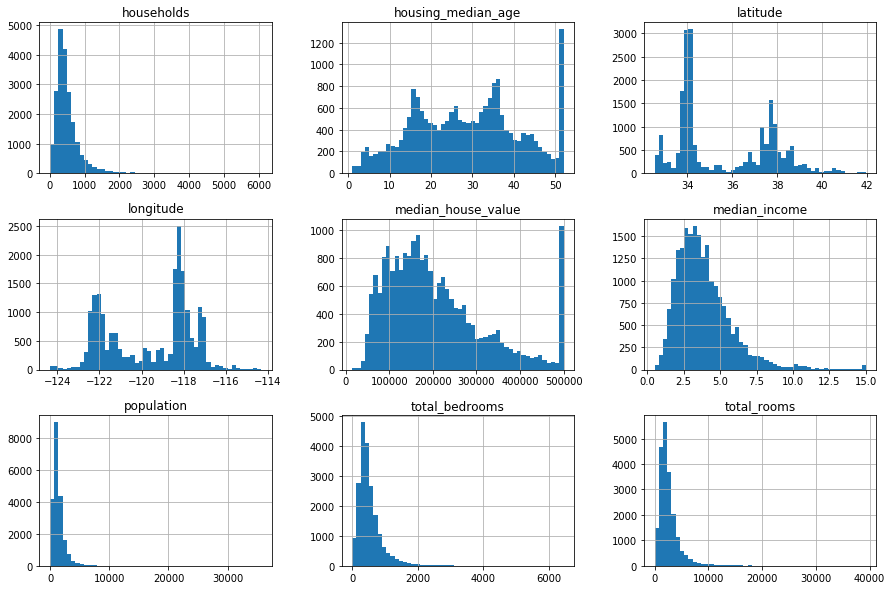

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline 

housing.hist(bins=50, figsize=(15, 10)) # histogram 그리기
plt.show()

## 3. 테스트 세트 만들기

### 3-1. 무작위 샘플링

In [20]:
import numpy as np

In [21]:
np.random.permutation(len(housing))[:4128]

array([ 8796,  6911, 12469, ...,  3770, 17940,  8531])

In [24]:
import numpy as np

np.random.seed(42) # 항상 같은 테스트 셋이 나오도록

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))  # 인덱스 셔플 (0~data의 길이만큼 random하게)
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size] # test_set_size까지. random 배열을 가져옴.
    train_indices = shuffled_indices[test_set_size:] # 나머지.
    return data.iloc[train_indices], data.iloc[test_indices]


##### 주의사항: 데이터를 더 깊게 들여다보기 전에 테스트 세트를 따로 떼어놓아야 함. (뇌가 오버피팅 되어 특정 모델을 선택하는 것을 막자.)

In [25]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), 'train +', len(test_set), 'test')


16512 train + 4128 test


In [26]:
from sklearn.model_selection import train_test_split

In [27]:
# train_test_split(housing.index, 0.2)

#### 순수 무작위 샘플링 - (데이터셋이 충분히 크면 괜찮지만, 샘플링 편향 위험성)  => 계층적 샘플링이 필요

### 3-2. 층화추출법 (계층적 샘플링)

##### 계층적 샘플링: 테스트세트가 전체 모집단을 대표하도록 샘플링. (예. 남여 비율이 52:48 이라면 테스트셋도 마찬가지 비율로)

##### median_income을 기준으로 샘플링.  => income_cat이라는 컬럼으로

In [31]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [39]:
housing['median_income']

0        8.3252
1        8.3014
2        7.2574
3        5.6431
4        3.8462
5        4.0368
6        3.6591
7        3.1200
8        2.0804
9        3.6912
10       3.2031
11       3.2705
12       3.0750
13       2.6736
14       1.9167
15       2.1250
16       2.7750
17       2.1202
18       1.9911
19       2.6033
20       1.3578
21       1.7135
22       1.7250
23       2.1806
24       2.6000
25       2.4038
26       2.4597
27       1.8080
28       1.6424
29       1.6875
          ...  
20610    1.3631
20611    1.2857
20612    1.4934
20613    1.4958
20614    2.4695
20615    2.3598
20616    2.0469
20617    3.3021
20618    2.2500
20619    2.7303
20620    4.5625
20621    2.3661
20622    2.4167
20623    2.8235
20624    3.0739
20625    4.1250
20626    2.1667
20627    3.0000
20628    2.5952
20629    2.0943
20630    3.5673
20631    3.5179
20632    3.1250
20633    2.5495
20634    3.7125
20635    1.5603
20636    2.5568
20637    1.7000
20638    1.8672
20639    2.3886
Name: median_income, Len

In [42]:
# 계층적 샘플링을 위한 income_cat
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)  # income의 카테고리 수 제한
housing['income_cat']

0        6.0
1        6.0
2        5.0
3        4.0
4        3.0
5        3.0
6        3.0
7        3.0
8        2.0
9        3.0
10       3.0
11       3.0
12       3.0
13       2.0
14       2.0
15       2.0
16       2.0
17       2.0
18       2.0
19       2.0
20       1.0
21       2.0
22       2.0
23       2.0
24       2.0
25       2.0
26       2.0
27       2.0
28       2.0
29       2.0
        ... 
20610    1.0
20611    1.0
20612    1.0
20613    1.0
20614    2.0
20615    2.0
20616    2.0
20617    3.0
20618    2.0
20619    2.0
20620    4.0
20621    2.0
20622    2.0
20623    2.0
20624    3.0
20625    3.0
20626    2.0
20627    2.0
20628    2.0
20629    2.0
20630    3.0
20631    3.0
20632    3.0
20633    2.0
20634    3.0
20635    2.0
20636    2.0
20637    2.0
20638    2.0
20639    2.0
Name: income_cat, Length: 20640, dtype: float64

In [43]:
housing['income_cat'].describe()

count    20640.000000
mean         3.093362
std          1.303707
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         11.000000
Name: income_cat, dtype: float64

In [44]:

# where절 사용법: 
# where(cond, other, inplace): cond가 True => 원래값 유지, cond가 False면 other로 설정 함. inplace가 True면 중복값 덮어쓰기.
housing['income_cat'].where(housing['income_cat'] < 6, 6.0, inplace=True) # 6보다 큰 카테고리는 6로 합치자. (소득 카테고리를 나눔)
housing.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,6.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,6.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3.0
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY,3.0
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY,3.0
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY,3.0
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,2.0
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY,3.0


In [45]:
housing['income_cat'].describe()

count    20640.000000
mean         3.052180
std          1.156297
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: income_cat, dtype: float64

In [46]:
housing['income_cat'].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.068944
6.0    0.045494
1.0    0.039826
Name: income_cat, dtype: float64

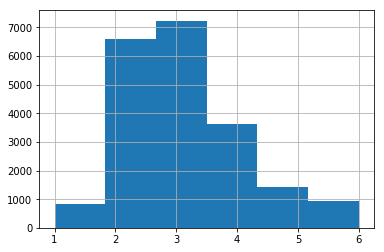

In [47]:
housing['income_cat'].hist(bins=6)

### 계층 샘플링 - sklearn-> StratifiedShuffleSplit

In [48]:
from sklearn.model_selection import StratifiedShuffleSplit

In [49]:
# StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
split

StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2,
            train_size=None)

In [53]:

# split.split => generator
for train_idx, test_idx in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_idx]
    strat_test_set = housing.loc[test_idx]


In [54]:
len(strat_train_set), len(strat_test_set)

(16512, 4128)

#### 비율 비교

In [55]:
original_strat_ratio = housing['income_cat'].value_counts() / len(housing)
print("모집단 비율")
print(original_strat_ratio)

print("\n 테스트 비율")
test_strat_ratio = strat_test_set['income_cat'].value_counts()/len(strat_test_set)
print(test_strat_ratio)

print("\n 층화추출법: 모집단 비율 - 샘플링 비율")
print(abs(original_strat_ratio - test_strat_ratio))

모집단 비율
3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.068944
6.0    0.045494
1.0    0.039826
Name: income_cat, dtype: float64

 테스트 비율
3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.069041
6.0    0.045543
1.0    0.039729
Name: income_cat, dtype: float64

 층화추출법: 모집단 비율 - 샘플링 비율
3.0    0.000048
2.0    0.000048
4.0    0.000048
5.0    0.000097
6.0    0.000048
1.0    0.000097
Name: income_cat, dtype: float64


In [58]:
# 만약 무작위 샘플링이라면
shuffle_test = split_train_test(housing, 0.2)[1]

o_shuffle_ratio = housing['income_cat'].value_counts() / len(housing)
print("모집단 비율")
print(o_shuffle_ratio)
print()

t_shuffle_ratio = shuffle_test['income_cat'].value_counts()/len(shuffle_test)
print("\n 테스트 비율")
print(t_shuffle_ratio)

print()
print("\n 무작위 추출법: 모집단 비율 - 샘플링 비율")
print(abs(o_shuffle_ratio-t_shuffle_ratio))

모집단 비율
3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.068944
6.0    0.045494
1.0    0.039826
Name: income_cat, dtype: float64


 테스트 비율
3.0    0.351017
2.0    0.318556
4.0    0.175630
5.0    0.071463
6.0    0.046027
1.0    0.037306
Name: income_cat, dtype: float64


 무작위 추출법: 모집단 비율 - 샘플링 비율
3.0    0.000436
2.0    0.000291
4.0    0.000678
5.0    0.002519
6.0    0.000533
1.0    0.002519
Name: income_cat, dtype: float64


In [59]:
# income cat 삭제. (표본 나눴으니.)
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## 4. 데이터 이해를 위한 탐색과 시각화

In [60]:
housing = strat_train_set.copy() # 훈련 셋 손상시키지 않기 위한 복사본

### 4-1. 위치데이터 시각화

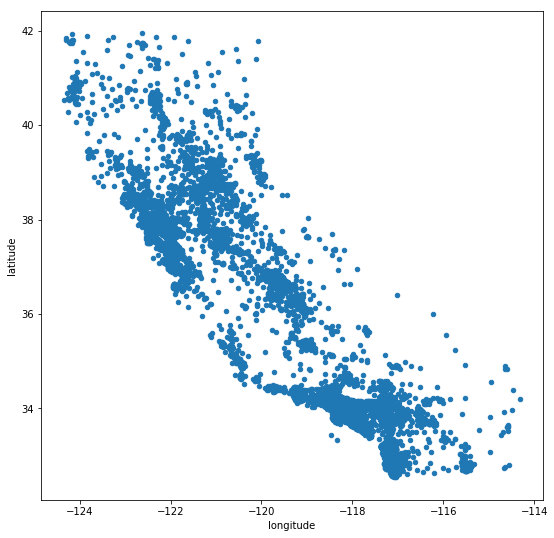

In [61]:
import matplotlib.image as mpimg

housing_plot = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(9, 9))
housing_plot.set_xlabel('longitude')
housing_plot.set_ylabel('latitude')
plt.show()


NameError: name 'map_img' is not defined

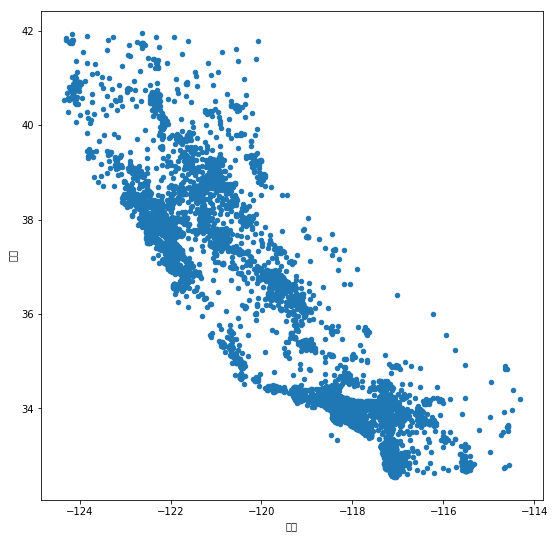

In [63]:
# 지도 출처: https://upload.wikimedia.org/wikipedia/commons/archive/f/f9/20090605191745%21USA_California_location_map.svg
# map_img = mpimg.imread('datasets/housing/califonia.png')

housing_plot = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(9, 9))
housing_plot.set_xlabel('경도')
housing_plot.set_ylabel('위도')
plt.imshow(map_img, extent=[-124.7, -113.9, 32.3, 42.2], alpha=0.6)

##### 밀집도 추가

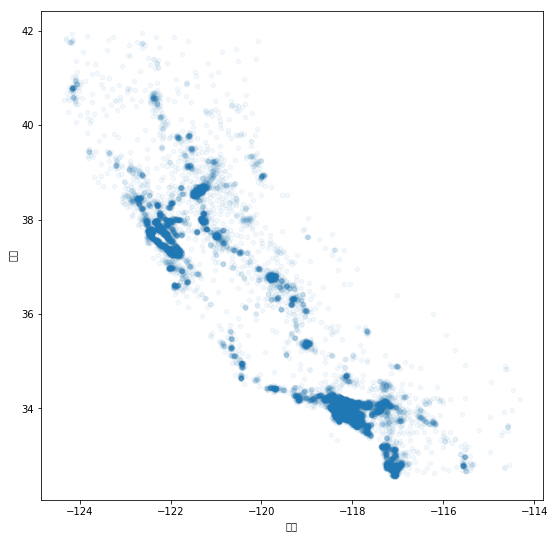

In [65]:
housing_plot = housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.05, figsize=(9, 9))
housing_plot.set_xlabel('경도')
housing_plot.set_ylabel('위도')
# plt.imshow(map_img, extent=[-124.7, -113.9, 32.3, 42.2], alpha=0.6)

plt.show()

### 데이터 추가하기(집 가격, 인구수)

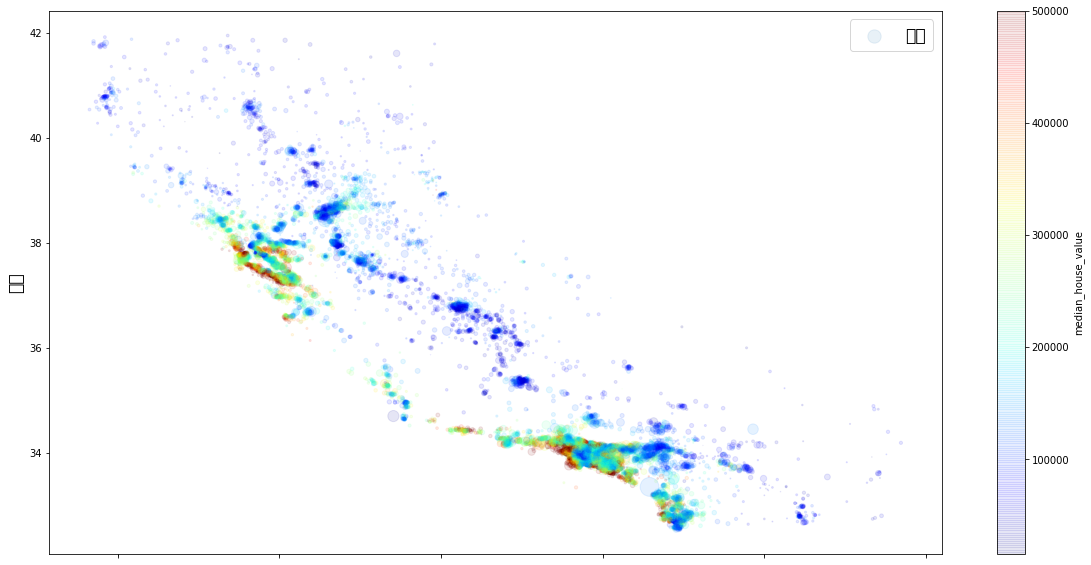

In [68]:
from matplotlib import pyplot  as plt


housing_plot = housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1,
                            s=housing['population']/100, c="median_house_value", 
                            cmap=plt.get_cmap("jet"), colorbar=True,  figsize=(20,10))

housing_plot.set_xlabel('경도', fontsize='xx-large')
housing_plot.set_ylabel('위도', fontsize='xx-large')
# plt.imshow(map_img, extent=[-124.7, -113.9, 32.3, 42.2], alpha=0.6)


plt.legend(('인구',), fontsize='xx-large')

### 4-2. 상관관계 조사

#### 표준 상관계수: Standard correlation coefficient - 피어슨 r (corr())

In [69]:
corr_matrix = housing.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924528,-0.107785,0.047801,0.074600,0.106495,0.061007,-0.015011,-0.045270
latitude,-0.924528,1.000000,0.007503,-0.038804,-0.071162,-0.114462,-0.076343,-0.078346,-0.144204
housing_median_age,-0.107785,0.007503,1.000000,-0.364634,-0.324872,-0.299595,-0.306882,-0.115680,0.111570
total_rooms,0.047801,-0.038804,-0.364634,1.000000,0.928754,0.856439,0.917713,0.201676,0.135386
total_bedrooms,0.074600,-0.071162,-0.324872,0.928754,1.000000,0.876627,0.979970,-0.007201,0.048975
population,0.106495,-0.114462,-0.299595,0.856439,0.876627,1.000000,0.905145,0.007156,-0.024114
households,0.061007,-0.076343,-0.306882,0.917713,0.979970,0.905145,1.000000,0.013939,0.066012
median_income,-0.015011,-0.078346,-0.115680,0.201676,-0.007201,0.007156,0.013939,1.000000,0.685600
median_house_value,-0.045270,-0.144204,0.111570,0.135386,0.048975,-0.024114,0.066012,0.685600,1.000000


In [70]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.685600
total_rooms           0.135386
housing_median_age    0.111570
households            0.066012
total_bedrooms        0.048975
population           -0.024114
longitude            -0.045270
latitude             -0.144204
Name: median_house_value, dtype: float64

In [71]:
attributes = ['housing_median_age', "total_rooms", "total_bedrooms", "population", "households", "median_income", "median_house_value"]
corr_matrix[attributes]

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,-0.107785,0.047801,0.074600,0.106495,0.061007,-0.015011,-0.045270
latitude,0.007503,-0.038804,-0.071162,-0.114462,-0.076343,-0.078346,-0.144204
housing_median_age,1.000000,-0.364634,-0.324872,-0.299595,-0.306882,-0.115680,0.111570
total_rooms,-0.364634,1.000000,0.928754,0.856439,0.917713,0.201676,0.135386
total_bedrooms,-0.324872,0.928754,1.000000,0.876627,0.979970,-0.007201,0.048975
population,-0.299595,0.856439,0.876627,1.000000,0.905145,0.007156,-0.024114
households,-0.306882,0.917713,0.979970,0.905145,1.000000,0.013939,0.066012
median_income,-0.115680,0.201676,-0.007201,0.007156,0.013939,1.000000,0.685600
median_house_value,0.111570,0.135386,0.048975,-0.024114,0.066012,0.685600,1.000000


In [72]:
%matplotlib inline

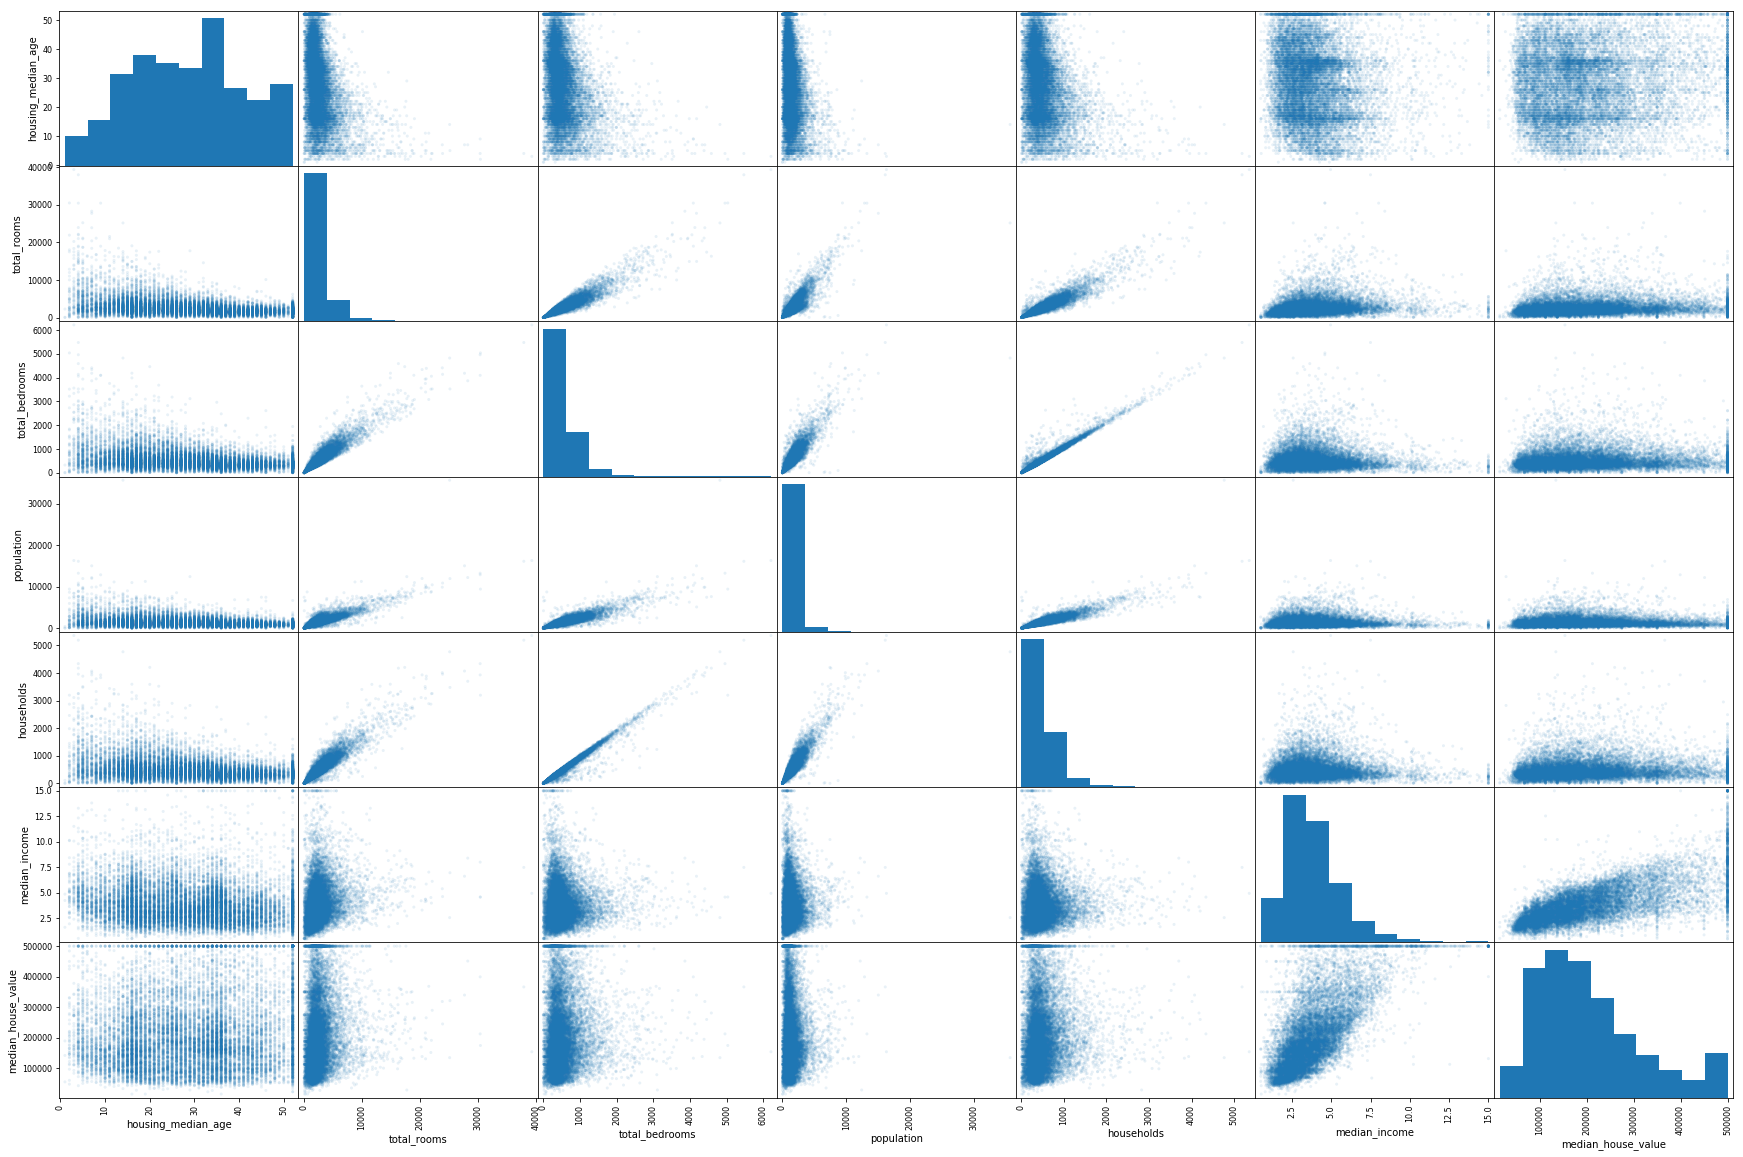

In [73]:
from pandas.plotting import scatter_matrix

scatter_matrix(housing[attributes], figsize=(30, 20), alpha=0.1)
plt.show()


In [ ]:
# median_income 과 median_house_value가 상관관계

### 4-3. 특성 조합

In [74]:
housing['rooms_per_houshold'] = housing['total_rooms']/housing['households'] # 가구당 방 개수
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms'] # 전체 방당 침실개수
housing['bedrooms_per_household'] = housing['total_bedrooms']/housing['households'] # 가구당 침실개수
housing['population_per_household'] = housing['population']/housing['households'] # 평균 한 가구 인원

In [75]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

# 추가 특성
# rooms_per_houshold , bedrooms_per_room 가 다른 특성보다 상관관계가 높은편!

median_house_value          1.000000
median_income               0.685600
rooms_per_houshold          0.144217
total_rooms                 0.135386
housing_median_age          0.111570
households                  0.066012
total_bedrooms              0.048975
population_per_household   -0.021634
population                 -0.024114
bedrooms_per_household     -0.043957
longitude                  -0.045270
latitude                   -0.144204
bedrooms_per_room          -0.258208
Name: median_house_value, dtype: float64

## 5. 데이터처리 - 머신러닝 알고리즘 위한 데이터 준비

In [ ]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set['median_house_value'].copy()
# housing복사본 만듬 -> 예측 변수만 분리

In [ ]:
housing.info()

### 5-0. 데이터 이해하기

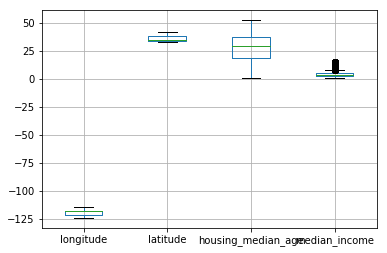

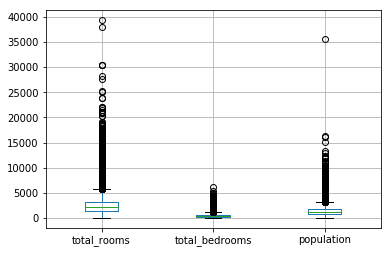

In [76]:
# boxplot
plt.figure(1)
box_plot_attr = ['longitude', 'latitude', 'housing_median_age', 'median_income']
housing.boxplot(box_plot_attr, figsize=(9,9))

plt.figure(2)
box_plot_attr2 = ['total_rooms', 'total_bedrooms', 'population']
housing.boxplot(box_plot_attr2, figsize=(9,9))


In [77]:
corr = housing.corr()
corr.style.background_gradient(cmap='coolwarm')


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_houshold,bedrooms_per_room,bedrooms_per_household,population_per_household
longitude,1,-0.924528,-0.107785,0.0478015,0.0746004,0.106495,0.0610074,-0.0150113,-0.0452705,-0.0263792,0.0924867,0.0124172,-0.000421697
latitude,-0.924528,1,0.0075026,-0.038804,-0.0711623,-0.114462,-0.0763432,-0.0783456,-0.144204,0.106097,-0.114499,0.0707156,0.00540801
housing_median_age,-0.107785,0.0075026,1,-0.364634,-0.324872,-0.299595,-0.306882,-0.11568,0.11157,-0.148457,0.140324,-0.0742501,0.015052
total_rooms,0.0478015,-0.038804,-0.364634,1,0.928754,0.856439,0.917713,0.201676,0.135386,0.129225,-0.194467,0.026112,-0.0244897
total_bedrooms,0.0746004,-0.0711623,-0.324872,0.928754,1,0.876627,0.97997,-0.00720105,0.0489746,0.00240428,0.0841299,0.0426536,-0.0283098
population,0.106495,-0.114462,-0.299595,0.856439,0.876627,1,0.905145,0.00715647,-0.0241138,-0.0713306,0.0338384,-0.0678932,0.0758808
households,0.0610074,-0.0763432,-0.306882,0.917713,0.97997,0.905145,1,0.0139388,0.0660123,-0.0806507,0.0642967,-0.0580947,-0.0273618
median_income,-0.0150113,-0.0783456,-0.11568,0.201676,-0.00720105,0.00715647,0.0139388,1,0.6856,0.308593,-0.624776,-0.0611958,0.0224968
median_house_value,-0.0452705,-0.144204,0.11157,0.135386,0.0489746,-0.0241138,0.0660123,0.6856,1,0.144217,-0.258208,-0.0439571,-0.0216336
rooms_per_houshold,-0.0263792,0.106097,-0.148457,0.129225,0.00240428,-0.0713306,-0.0806507,0.308593,0.144217,1,-0.398711,0.863249,-0.00509624


###  5-1. 결측값 처리

##### 5-1-1. 삭제

In [78]:
# 삭제
# housing.dropna(subset=['total_bedrooms']) 
housing.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16358 entries, 6895 to 15088
Data columns (total 14 columns):
longitude                   16358 non-null float64
latitude                    16358 non-null float64
housing_median_age          16358 non-null float64
total_rooms                 16358 non-null float64
total_bedrooms              16358 non-null float64
population                  16358 non-null float64
households                  16358 non-null float64
median_income               16358 non-null float64
median_house_value          16358 non-null float64
ocean_proximity             16358 non-null object
rooms_per_houshold          16358 non-null float64
bedrooms_per_room           16358 non-null float64
bedrooms_per_household      16358 non-null float64
population_per_household    16358 non-null float64
dtypes: float64(13), object(1)
memory usage: 1.9+ MB


In [79]:
# 열 제거
housing.drop('total_bedrooms', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 6895 to 15088
Data columns (total 13 columns):
longitude                   16512 non-null float64
latitude                    16512 non-null float64
housing_median_age          16512 non-null float64
total_rooms                 16512 non-null float64
population                  16512 non-null float64
households                  16512 non-null float64
median_income               16512 non-null float64
median_house_value          16512 non-null float64
ocean_proximity             16512 non-null object
rooms_per_houshold          16512 non-null float64
bedrooms_per_room           16358 non-null float64
bedrooms_per_household      16358 non-null float64
population_per_household    16512 non-null float64
dtypes: float64(12), object(1)
memory usage: 1.8+ MB


##### 5-1-2. 대표값으로 대체

In [80]:
housing.median()

longitude                     -118.510000
latitude                        34.260000
housing_median_age              29.000000
total_rooms                   2123.500000
total_bedrooms                 433.500000
population                    1166.000000
households                     408.000000
median_income                    3.540900
median_house_value          179500.000000
rooms_per_houshold               5.232342
bedrooms_per_room                0.203021
bedrooms_per_household           1.048617
population_per_household         2.820179
dtype: float64

In [81]:
# 대표값으로 대체

# median = housing['total_bedrooms'].median() # option3: 중간값 채우기
# housing['total_bedrooms'] = housing['total_bedrooms'].fillna(median)
# housing.info()
median = housing.median()
# print(housing.fillna(median).describe())
housing.fillna(median).info()


# housing.info()
# 중간값 계산할 경우. 저장해 놓아야함( 테스트셋에서도 누락된 값을 바꾸고, 실제 운영시에도 바꿔야 함.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 6895 to 15088
Data columns (total 14 columns):
longitude                   16512 non-null float64
latitude                    16512 non-null float64
housing_median_age          16512 non-null float64
total_rooms                 16512 non-null float64
total_bedrooms              16512 non-null float64
population                  16512 non-null float64
households                  16512 non-null float64
median_income               16512 non-null float64
median_house_value          16512 non-null float64
ocean_proximity             16512 non-null object
rooms_per_houshold          16512 non-null float64
bedrooms_per_room           16512 non-null float64
bedrooms_per_household      16512 non-null float64
population_per_household    16512 non-null float64
dtypes: float64(13), object(1)
memory usage: 1.9+ MB


##### 5-1-2. 부록: imputer 사용하기

In [87]:
# strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 6895 to 15088
Data columns (total 10 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16358 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
median_house_value    16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


In [82]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
imputer

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

In [83]:
# imputer 사용하기: 수치형 특성에서만 계산될 수 있음.
housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

In [84]:
# imputer의 statistics에 저장됨.! (새로운 데이터에서 어떤 값이 누락될지 모르므로, 모든 수치형 특성에 imputer를 적용하자)
imputer.statistics_

array([-1.18510000e+02,  3.42600000e+01,  2.90000000e+01,  2.12350000e+03,
        4.33500000e+02,  1.16600000e+03,  4.08000000e+02,  3.54090000e+00,
        1.79500000e+05,  5.23234164e+00,  2.03020779e-01,  1.04861674e+00,
        2.82017903e+00])

In [85]:
housing_num.median().values

array([-1.18510000e+02,  3.42600000e+01,  2.90000000e+01,  2.12350000e+03,
        4.33500000e+02,  1.16600000e+03,  4.08000000e+02,  3.54090000e+00,
        1.79500000e+05,  5.23234164e+00,  2.03020779e-01,  1.04861674e+00,
        2.82017903e+00])

In [88]:
#imputer 객체로 훈련세트에서 누락된 값을 학습한 중간값으로 변경 
X = imputer.transform(housing_num)
X
# => 결과는 numpy 배열 (housing_num에서 변형된 특성) => pandas로 만들기

array([[-118.11      ,   34.04      ,   28.        , ...,    0.17786864,
           0.99856528,    3.2482066 ],
       [-118.97      ,   35.38      ,   35.        , ...,    0.2546324 ,
           1.031477  ,    2.52058111],
       [-117.03      ,   34.07      ,   16.        , ...,    0.15248414,
           1.09904762,    3.07619048],
       ...,
       [-122.58      ,   37.98      ,   52.        , ...,    0.18305085,
           1.0964467 ,    2.37055838],
       [-118.44      ,   34.21      ,   37.        , ...,    0.2012012 ,
           0.97667638,    2.94752187],
       [-116.91      ,   32.81      ,   22.        , ...,    0.1470792 ,
           0.97400612,    2.98470948]])

In [91]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=list(housing.index.values))
housing_tr.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_houshold,bedrooms_per_room,bedrooms_per_household,population_per_household
6895,-118.11,34.04,28.0,3913.0,696.0,2264.0,697.0,5.2446,258000.0,5.614060,0.177869,0.998565,3.248207
2880,-118.97,35.38,35.0,1673.0,426.0,1041.0,413.0,1.3750,57500.0,4.050847,0.254632,1.031477,2.520581
13769,-117.03,34.07,16.0,3784.0,577.0,1615.0,525.0,4.2333,220300.0,7.207619,0.152484,1.099048,3.076190
18349,-122.17,37.43,24.0,3924.0,1142.0,7174.0,950.0,4.0972,387500.0,4.130526,0.291030,1.202105,7.551579
16188,-121.31,37.96,48.0,1112.0,227.0,583.0,216.0,2.3393,77600.0,5.148148,0.204137,1.050926,2.699074
14468,-117.26,32.85,30.0,3652.0,499.0,978.0,462.0,8.2374,500001.0,7.904762,0.136637,1.080087,2.116883
6861,-118.13,34.06,30.0,1692.0,398.0,1130.0,365.0,2.8672,198500.0,4.635616,0.235225,1.090411,3.095890
17344,-120.43,34.86,17.0,3172.0,506.0,1538.0,473.0,4.3125,168100.0,6.706131,0.159521,1.069767,3.251586
3981,-118.60,34.19,16.0,14912.0,4183.0,5105.0,3302.0,2.8312,213900.0,4.516051,0.280512,1.266808,1.546033
19222,-122.70,38.46,29.0,2891.0,459.0,1012.0,441.0,5.0415,240200.0,6.555556,0.158769,1.040816,2.294785


##### 5-1-3. 예측값 삽입 (Feature를 위한 머신러닝)

In [92]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_houshold,bedrooms_per_room,bedrooms_per_household,population_per_household
count,16512.000000,16512.00000,16512.000000,16512.000000,16358.000000,16512.000000,16512.00000,16512.000000,16512.000000,16512.000000,16358.000000,16358.000000,16512.000000
mean,-119.572346,35.63674,28.628513,2628.114583,535.663529,1422.758600,497.75327,3.873473,206893.947614,5.438873,0.212863,1.098661,3.098006
std,2.001511,2.13778,12.586026,2157.526589,413.333152,1120.859666,376.32796,1.900464,115457.615892,2.606392,0.057366,0.508801,11.585044
min,-124.350000,32.54000,1.000000,6.000000,1.000000,3.000000,1.00000,0.499900,14999.000000,1.130435,0.100000,0.333333,0.692308
25%,-121.800000,33.93000,18.000000,1445.000000,295.000000,786.000000,279.00000,2.566775,119800.000000,4.441216,0.175247,1.005556,2.431714
50%,-118.510000,34.26000,29.000000,2123.500000,433.500000,1166.000000,408.00000,3.540900,179500.000000,5.232342,0.203021,1.048617,2.820179
75%,-118.010000,37.72000,37.000000,3143.250000,645.000000,1720.000000,603.00000,4.744475,264000.000000,6.056697,0.239774,1.099330,3.282433
max,-114.310000,41.95000,52.000000,39320.000000,6210.000000,35682.000000,5358.00000,15.000100,500001.000000,141.909091,1.000000,34.066667,1243.333333


### 5-2. 텍스트와 범주형 특성 다루기

##### 5-2-1. LabelEncoding 예시

In [93]:
housing_cat = housing['ocean_proximity']
housing_cat.head(10)

6895      <1H OCEAN
2880         INLAND
13769        INLAND
18349    NEAR OCEAN
16188        INLAND
14468    NEAR OCEAN
6861      <1H OCEAN
17344     <1H OCEAN
3981      <1H OCEAN
19222     <1H OCEAN
Name: ocean_proximity, dtype: object

In [94]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     7273
INLAND        5268
NEAR OCEAN    2114
NEAR BAY      1855
ISLAND           2
Name: ocean_proximity, dtype: int64

In [95]:
# 머신러닝 알고리즘은 대부분 숫자형을 다룸 -> 각 카테고리를 다른 정숫값으로 매핑
housing_cat_encoded, housing_categories = housing_cat.factorize()
housing_cat_encoded[:10]


array([0, 1, 1, 2, 1, 2, 0, 0, 0, 0], dtype=int64)

In [96]:
housing_categories

Index(['<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'NEAR BAY', 'ISLAND'], dtype='object')


##### 5-2-2. OnehotEncoding 예시

In [98]:
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(categories='auto')
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

### 5-3. feature scaling

In [99]:
# 스케일링을 비슷하게 만들어준다. (0~1사이에 위치하도록)
# 1. min-max 스케일링: (data-min_value)/(max_value-min_value) 
# MinMaxScaler변환기

# 2. 표준화: (data-mean)/std ==> 분산이 1이 됨: 평균이 0이 됨
# StandardScaler 변환기
# 범위의 상한과 하한이 없어서 신경망에서는 사용 못함.
# 그러나 표준화는 이상치에 영향을 덜 받음.

# 만약 중간소득을 실수로 100이라고 입력한 구역이 있으면,,,, 
# min-max는 0~15사이에 모든 값을 0~0.15로 만듬
# 표준화는 크게 영향 받지 않음(평균으로 하기 때문에.)

housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_houshold,bedrooms_per_room,bedrooms_per_household,population_per_household
count,16512.000000,16512.00000,16512.000000,16512.000000,16358.000000,16512.000000,16512.00000,16512.000000,16512.000000,16512.000000,16358.000000,16358.000000,16512.000000
mean,-119.572346,35.63674,28.628513,2628.114583,535.663529,1422.758600,497.75327,3.873473,206893.947614,5.438873,0.212863,1.098661,3.098006
std,2.001511,2.13778,12.586026,2157.526589,413.333152,1120.859666,376.32796,1.900464,115457.615892,2.606392,0.057366,0.508801,11.585044
min,-124.350000,32.54000,1.000000,6.000000,1.000000,3.000000,1.00000,0.499900,14999.000000,1.130435,0.100000,0.333333,0.692308
25%,-121.800000,33.93000,18.000000,1445.000000,295.000000,786.000000,279.00000,2.566775,119800.000000,4.441216,0.175247,1.005556,2.431714
50%,-118.510000,34.26000,29.000000,2123.500000,433.500000,1166.000000,408.00000,3.540900,179500.000000,5.232342,0.203021,1.048617,2.820179
75%,-118.010000,37.72000,37.000000,3143.250000,645.000000,1720.000000,603.00000,4.744475,264000.000000,6.056697,0.239774,1.099330,3.282433
max,-114.310000,41.95000,52.000000,39320.000000,6210.000000,35682.000000,5358.00000,15.000100,500001.000000,141.909091,1.000000,34.066667,1243.333333


##### 5-3-1. min-max scaling (min-max normalization)

In [100]:
from sklearn.preprocessing import MinMaxScaler

A = MinMaxScaler().fit_transform(housing.drop('ocean_proximity',axis=1))
min_max_columns = housing.columns.copy().drop('ocean_proximity')

min_max_housing = pd.DataFrame(A, columns=min_max_columns, index=housing.index)

min_max_housing.describe()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_houshold,bedrooms_per_room,bedrooms_per_household,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16358.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16358.000000,16358.000000,16512.000000
mean,0.475862,0.329090,0.541736,0.066697,0.086111,0.039793,0.092730,0.232657,0.395658,0.030604,0.125403,0.022688,0.001936
std,0.199354,0.227182,0.246785,0.054879,0.066570,0.031415,0.070250,0.131065,0.238056,0.018514,0.063740,0.015083,0.009323
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.253984,0.147715,0.333333,0.036603,0.047351,0.021946,0.051895,0.142541,0.216084,0.023518,0.083608,0.019928,0.001400
50%,0.581673,0.182784,0.549020,0.053861,0.069657,0.032596,0.075975,0.209721,0.339176,0.029137,0.114468,0.021204,0.001712
75%,0.631474,0.550478,0.705882,0.079800,0.103720,0.048124,0.112376,0.292725,0.513402,0.034993,0.155304,0.022707,0.002084
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


##### 5-3-2. Standardization

In [101]:
from sklearn.preprocessing import StandardScaler

B = StandardScaler().fit_transform(housing.drop('ocean_proximity',axis=1))
std_columns = housing.columns.copy().drop('ocean_proximity')

std_housing = pd.DataFrame(B, columns=std_columns, index=housing.index)

std_housing.describe()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_houshold,bedrooms_per_room,bedrooms_per_household,population_per_household
count,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.635800e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.635800e+04,1.635800e+04,1.651200e+04
mean,-8.221554e-15,-3.073271e-15,-1.182705e-17,-5.843598e-17,1.368690e-16,-6.125322e-18,1.213298e-17,5.940419e-17,7.646567e-18,-6.878044e-17,3.734226e-17,6.692694e-17,4.222831e-17
std,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000031e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000031e+00,1.000031e+00,1.000030e+00
min,-2.387097e+00,-1.448621e+00,-2.195240e+00,-1.215370e+00,-1.293581e+00,-1.266708e+00,-1.320041e+00,-1.775185e+00,-1.662088e+00,-1.653078e+00,-1.967480e+00,-1.504226e+00,-2.076618e-01
25%,-1.113020e+00,-7.983943e-01,-8.444949e-01,-5.483828e-01,-5.822685e-01,-5.681156e-01,-5.813012e-01,-6.875886e-01,-7.543598e-01,-3.827848e-01,-6.557416e-01,-1.829963e-01,-5.751484e-02
50%,5.307880e-01,-6.440239e-01,2.951676e-02,-2.338928e-01,-2.471775e-01,-2.290799e-01,-2.385047e-01,-1.750008e-01,-2.372713e-01,-7.924265e-02,-1.715756e-01,-9.836104e-02,-2.398226e-02
75%,7.806068e-01,9.745262e-01,6.651616e-01,2.387693e-01,2.645319e-01,2.651986e-01,2.796760e-01,4.583244e-01,4.946212e-01,2.370493e-01,4.691227e-01,1.314342e-03,1.591991e-02
max,2.629267e+00,2.953274e+00,1.856996e+00,1.700697e+01,1.372866e+01,3.056607e+01,1.291531e+01,5.854869e+00,2.538732e+00,5.236141e+01,1.372172e+01,6.479749e+01,1.070581e+02


### 5-4. 변환 파이프라인

##### 5-4-1. 변환기 만들기

In [105]:
# 변환기 만들기
# fit과 transform
from sklearn.base import BaseEstimator, TransformerMixin

rooms_idx, bedrooms_idx, population_idx, household_idx = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_idx] / X[:, household_idx]
        population_per_household = X[:, population_idx]/X[:, household_idx]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_idx] / X[:, rooms_idx]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [106]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr

# 모든 파이프라인은 (이름, 추정기)
# 마지막 단계에서는 반드시 fit_transform()메소드를 가지고 있어야 함
# 파이프라인이 하나씩 호출하면서 출력을 다음 단계의 입력으로 전달함.

array([[ 0.73064307, -0.74693746, -0.04993885, ...,  0.06721658,
         0.01296542, -0.54866676],
       [ 0.30095459, -0.12010014,  0.50625037, ..., -0.53256277,
        -0.04984379,  0.62774704],
       [ 1.27025185, -0.73290379, -1.00340609, ...,  0.6786392 ,
        -0.00188314, -0.93768728],
       ...,
       [-1.50273773,  1.09615139,  1.85699563, ...,  0.21140012,
        -0.06279387, -0.46924885],
       [ 0.56576261, -0.66741332,  0.66516158, ..., -0.22431894,
        -0.01298992, -0.19109249],
       [ 1.33020838, -1.32231799, -0.52667247, ...,  0.45407106,
        -0.00977986, -1.02051875]])

##### 데이터프레임 셀렉터 클래스 - 파이프라인 처리하기

In [107]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    """
    데이터프레임에서 필요한 속성만 셀렉트하도록
    """
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values

##### 5-4.2 파이프라인 연결하기

In [109]:
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder',  OneHotEncoder(categories='auto',sparse=False)),
])



In [110]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])
full_pipeline

FeatureUnion(n_jobs=None,
       transformer_list=[('num_pipeline', Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'rooms_per_houshold', 'bedrooms_per_...     dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=False))]))],
       transformer_weights=None)

In [111]:
# pipeline 실행
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[ 0.73064307, -0.74693746, -0.04993885, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.30095459, -0.12010014,  0.50625037, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.27025185, -0.73290379, -1.00340609, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.50273773,  1.09615139,  1.85699563, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.56576261, -0.66741332,  0.66516158, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.33020838, -1.32231799, -0.52667247, ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
housing_prepared.shape

In [115]:
housing_prepared

array([[ 0.73064307, -0.74693746, -0.04993885, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.30095459, -0.12010014,  0.50625037, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.27025185, -0.73290379, -1.00340609, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.50273773,  1.09615139,  1.85699563, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.56576261, -0.66741332,  0.66516158, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.33020838, -1.32231799, -0.52667247, ...,  0.        ,
         0.        ,  0.        ]])

## 6. 모델 선택과 훈련

우린 다음을 수행했음
1. 문제 정의
2. 데이터 읽고 탐색
3. 훈련세트와 테스트 세트 나누고
4. 머신러닝 알고리즘에 주입할 데이터를 자동으로 정제하고 준비하기 위해 변환 파이프라인 작성
5. ---- 머신러닝 모델 선택하고 훈련하자

#### 훈련하기1 - LinearRegression

In [121]:
housing_labels = housing_num['median_house_value']

In [122]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

#### 훈련평가하기1 - LinearRegression

In [123]:
# lin_reg.score(housing_prepared, housing_labels)

1.0

In [124]:
some_data = housing.iloc[:10]
some_labels = housing_labels.iloc[:10]
some_data_prepared = full_pipeline.transform(some_data)
print("예측: ", lin_reg.predict(some_data_prepared))
print("레이블: ", list(some_labels))

# 그닥 정확한 예측은 아니지만. 작동은 함

예측:  [258000.  57500. 220300. 387500.  77600. 500001. 198500. 168100. 213900.
 240200.]
레이블:  [258000.0, 57500.0, 220300.0, 387500.0, 77600.0, 500001.0, 198500.0, 168100.0, 213900.0, 240200.0]


In [126]:
# 전체 MSE측정
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)
lin_mse
# 이렇게 평가가 끝났음. => 좋은 점수가 아님. (과소적합!) 
# 이유는?: 모델이 안 좋거나, 특성들이 충분한 정보를 제공하지 못했거나.
# 해결책은?: 모델은 바꾸거나 더 좋은 특성을 주입하거나 모델의 규제를 감소시키거나

# dir(lin_reg)
# lin_reg.normalize

2.3446608830114537e-10


5.497434656324049e-20

#### 훈련하기2 - DecisionTreeRegressor

In [127]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

#### 훈련평가하기2 - DecisionTreeRegressor

In [128]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

## 과대적합... 
# 확신이 들기전까지는 테스트 셋 사용하지 말고, 
# 훈련은 훈련셋에 일부로, 나머지는 모델 검증에 사용

0.0

#### 훈련평가하기2-2. k-fold cross-validation (교차 검증) DecisionTree

In [129]:
# cv개로 나눠서 10번 훈련하고 평가하는데 
# 1개는 돌아가면서 검증 세트로
# 그 외 나머지는 훈련세트로 하여
# 스코어를 정함.
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
tree_rmse_scores

array([111.85752785, 213.76652195, 143.69443993, 110.42015459,
       106.96518394, 206.81162553, 206.9726425 , 125.17703998,
        92.8386707 , 203.7875775 ])

In [130]:
tree_rmse_scores.mean()

152.22913844627794

In [131]:
tree_rmse_scores.std()

47.09542415029665

#### 훈련평가하기1-2. k-fold cross-validation (교차 검증)  LinearRegression

In [132]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
lin_rmse_scores

array([1.42305951e-10, 1.04297602e-10, 1.38303140e-10, 1.42469728e-10,
       1.28773769e-10, 1.20936162e-10, 1.06226089e-10, 2.70430253e-10,
       1.55419397e-10, 1.61522801e-10])

In [133]:
lin_rmse_scores.mean()

1.4706848933501693e-10

In [134]:
lin_rmse_scores.std()

4.486925124150145e-11

#### 훈련하기3 - RandomForestRegressor
- 특성을 무작위로 선택해서 많은 결정 트리를 만들고 예측을 평균냄

In [135]:
# 앙상블 학습: 여러 다른 모델을 모아서 하나의 모델을 만드는 것
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
forest_reg

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

#### 훈련평가하기3 - RandomForestRegressor

In [136]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

51.702242368350895

#### 훈련평가하기3-2. k-fold cross-validation (교차 검증)  RandomForestRegressor

In [137]:
forest_mse_score = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)

forest_rmse_score = np.sqrt(-forest_mse_score)
forest_rmse_score

array([ 59.44150888,  66.07739977, 110.25986594, 130.13036863,
        70.06443344, 255.15952759, 121.47397807,  92.94071758,
       191.25455361,  88.46576458])

In [138]:
forest_rmse_score.mean()

# 역시 과대 적합 - 그래도 훨씬 나음

118.5268118083346

In [139]:
forest_rmse_score.std()

58.581929725132326

##### 과대적합 해결하기: 모델 간단히 하기 or regualrization or 더 많은 data
--> 가능성 있는 2~5개의 모델을 선정하는 것이 목적

***Tip:** pickle패키지나 joblib을 사용하여 사이킷런 모델을 간단하게 저장하자.

## 8. 모델 세뷰 튜닝
가능성 있는 모델들을 추렸다고 가정. -> 세부 튜닝해야 함

###  8-1-1. 그리드 탐색
단순한 방법: 하이퍼파라미터 조합을 찾을 때까지 수동으로 하이퍼파라미터를 조정하는 것.
- sklearn.model_selection import GridSearchCV
-> 가능한 모든 하이퍼파라미터 조합에 대해 교차 검증을 사용함.
- 비교적 적은 수의 조합을 탐구할 때 괜찮음

##### RandomForestRegressor에 대한 최적의 하이퍼파라미터 조합을 그리드 탐색

In [140]:
from sklearn.model_selection import GridSearchCV

# param_grid에 대한 첫번째 dict에 있는 하이퍼 파라미터의 조합을 시도,, 
# 그다음 두번째 dict에 대한 하이퍼 파라미터에 대한 조합을 시도
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}    
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring="neg_mean_squared_error", return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [141]:
# 최적의 조합
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [142]:
# 최적의 추정기
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [ ]:
# cv 결과
cvres = grid_search.cv_results_
cvres

In [ ]:
# 평가 점수
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)
    
# 살짝 낫쥬?

###  8-1-2. 랜덤 탐색
- 하이퍼파라미터 탐색 공간이 커지면 RandomizedSearchCV
- 각 반복마다 하이퍼파라미터에 임의의 수를 대입하여 지정한 횟수만큼 평가.

장점:
1. 랜덤 탐색 1,000회 반복시 하이퍼파라미터마다 각기 다른 1,000개의 값 탐색 (그리드는 몇개의 값만 탐색)
2. 단순히 반복 횟수를 조절 -> 컴퓨팅 자원을 제어할 수 있음

###  8-3. 앙상블 방법
- 최상의 모델을 연결해보기. (결정 트리의 앙상블인 랜덤 포레스트가 결정 트리 하나보다 더 성능이 좋은 것처럼)

###  8-4. 최상의 모델과 오차 분석
- 최상의 모델을 분석하면 문제에 대한 좋은 통찰력 얻을 수 있음.
- RandomForestRegressor가 정확한 예측을 만들기 위한 각 특성의 상대적인 중요도를 알려줌.


In [143]:
# feature에 대한 중요도를 확인할 수 있음.
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.82808100e-03, 6.18747291e-03, 5.44589475e-03, 1.07650104e-03,
       9.36677542e-04, 1.25907869e-03, 1.08623903e-03, 1.51420091e-01,
       6.77831044e-01, 1.19615276e-02, 1.17377642e-02, 1.09540981e-03,
       1.79650007e-02, 5.73154777e-03, 1.14945203e-02, 1.62629430e-02,
       6.51952188e-03, 6.37700232e-02, 3.46154011e-07, 1.14818633e-04,
       2.75496811e-04])

In [144]:
extra_attribs = ['rooms_per_household', 'population_per_household', 'bedrooms_per_room']
cat_one_hot_attribs = list(housing_categories)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

sorted(zip(feature_importances, attributes), reverse=True)

# 중요도가 확연히 보이쥬?

[(0.6778310444510959, 'median_house_value'),
 (0.15142009054040725, 'median_income'),
 (0.0637700232414489, 'INLAND'),
 (0.017965000736294826, 'population_per_household'),
 (0.016262942996157697, 'bedrooms_per_room'),
 (0.011961527587881335, 'rooms_per_houshold'),
 (0.011737764155846155, 'bedrooms_per_room'),
 (0.011494520267447588, 'population_per_household'),
 (0.00782808100362516, 'longitude'),
 (0.00651952187638268, '<1H OCEAN'),
 (0.006187472905966616, 'latitude'),
 (0.005731547768880693, 'rooms_per_household'),
 (0.0054458947531147404, 'housing_median_age'),
 (0.0012590786931170302, 'population'),
 (0.0010954098075781136, 'bedrooms_per_household'),
 (0.0010862390312285429, 'households'),
 (0.0010765010433352617, 'total_rooms'),
 (0.0009366775424126634, 'total_bedrooms'),
 (0.0002754968111026037, 'ISLAND'),
 (0.00011481863266504343, 'NEAR BAY'),
 (3.461540110209688e-07, 'NEAR OCEAN')]

##  8-5. 테스트 셋으로 시스템 평가하기

In [ ]:
# 테스트 셋에서 feature와 레이블을 얻은 후
# full_pipeline으로 데이터를 변환하고
# 최종 모델 평가

final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

final_rmse


##  9. 론칭, 모니터링, 유지보수

1. 모니터링 코드: 실시간 성능 체크 - 성능 떨어졌을시 알람
2. 시스템 예측 샘플링 및 평가 - 사람의 분석이 필요.
3. 입력 데이터 품질 평가 (시스템 입력을 모니터링 - 쓰레기가 들어가면 쓰레기가 나온다. (센서 고장 체크))
4. 새로운 데이터를 사용해 정기적으로 모델을 훈련 (자동화)